# Programming Problem 2: MEMM for NER (25 points)
Welcome to the programming portion of the assignment! Each assignment throughout the semester will have a written portion and a programming portion. We will be using [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true), so if you have never used it before, take a quick look through this introduction: [Working with Google Colab](https://docs.google.com/document/d/1LlnXoOblXwW3YX-0yG_5seTXJsb3kRdMMRYqs8Qqum4/edit?usp=sharing).

### Writing Code
Look for the keyword "TODO" and fill in your code in the empty space.
Feel free to add and delete arguments in function signatures, but be careful that you might need to change them in function calls which are already present in the notebook.

### Data preprocessing

In this section we will write code to load data and build the dataset for Named Entity Recognition.

In [1]:
import os
import re
import codecs

Write a function to load sentences.

In [2]:
def zero_digits(s):
    """
    Replace all digits in a string with zeros.
    """
    return re.sub('\d', '0', s)

def load_sentences(path):
    """
    Load sentences. A line must contain at least a word and its tag.
    Sentences are separated by empty lines.
    """
    sentences = []
    sentence = []
    for line in codecs.open(path, 'r', 'utf8'):
        line = zero_digits(line.rstrip())
        if not line:
            if len(sentence) > 0:
                if 'DOCSTART' not in sentence[0][0]:
                    sentences.append(sentence)
                sentence = []
        else:
            word = line.split()
            assert len(word) >= 2
            sentence.append(word)
    if len(sentence) > 0:
        if 'DOCSTART' not in sentence[0][0]:
            sentences.append(sentence)
    return sentences

Prepare the training/test data using the loaded sentences.

In [3]:
def create_dico(item_list):
    """
    Create a dictionary of items from a list of list of items.
    """
    assert type(item_list) is list
    dico = {}
    for items in item_list:
        for item in items:
            if item not in dico:
                dico[item] = 1
            else:
                dico[item] += 1
    return dico

In [4]:
def create_mapping(dico):
    """
    Create a mapping (item to ID / ID to item) from a dictionary.
    Items are ordered by decreasing frequency.
    """
    sorted_items = sorted(dico.items(), key=lambda x: (-x[1], x[0]))
    id_to_item = {i: v[0] for i, v in enumerate(sorted_items) if v[1] > 2}
    item_to_id = {v: k for k, v in id_to_item.items()}
    return item_to_id, id_to_item

def word_mapping(sentences):
    """
    Create a dictionary and a mapping of words, sorted by frequency.
    """
    words = [[x[0] for x in s] for s in sentences]
    dico = create_dico(words)
    dico['<UNK>'] = 10000000
    word_to_id, id_to_word = create_mapping(dico)
    print("Found %i unique words (%i in total)" % (
        len(dico), sum(len(x) for x in words))
    )
    return dico, word_to_id, id_to_word

def tag_mapping(sentences):
    """
    Create a dictionary and a mapping of tags, sorted by frequency.
    """
    tags = [[word[-1] for word in s] for s in sentences]
    dico = create_dico(tags)
    tag_to_id, id_to_tag = create_mapping(dico)
    print("Found %i unique named entity tags" % len(dico))
    return dico, tag_to_id, id_to_tag

In [5]:
def prepare_dataset(sentences, mode=None, word_to_id=None, tag_to_id=None):
    """
    Prepare the dataset. Return 'data', which is a list of lists of dictionaries containing:
        - words (strings)
        - word indexes
        - tag indexes
    """
    assert mode == 'train' or (mode == 'test' and word_to_id and tag_to_id)

    if mode=='train':
        word_dic, word_to_id, id_to_word = word_mapping(sentences)
        tag_dic, tag_to_id, id_to_tag = tag_mapping(sentences)

    def f(x): return x
    data = []
    for s in sentences:
        str_words = [w[0] for w in s]
        words = [word_to_id[f(w) if f(w) in word_to_id else '<UNK>']
                 for w in str_words]
        tags = [tag_to_id[w[-1]] for w in s]
        data.append({
            'str_words': str_words,
            'words': words,
            'tags': tags,
        })

    if mode == 'train':
        return data, {'word_to_id':word_to_id, 'id_to_word':id_to_word, 'tag_to_id':tag_to_id, 'id_to_tag':id_to_tag}
    else:
        return data

### Maximum Entropy Markov Model
In this section, we will implement a maximum entropy markov model (MEMM).


In [6]:
import os
import re
import numpy as np
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse
import collections
import codecs

## Implement MEMM extract_feature for problem 2(a)

In [ ]:
class MEMM(object):
    """
     MEMM Model
    """
    def __init__(self, dic, decode_type, regex_features, rear_context_window=4, forward_context_window=4, num_prior_tags=6):
        """
        Initialize the model.
        """

        self.num_words = len(dic['word_to_id'])
        self.num_tags = len(dic['tag_to_id'])

        self.rear_context_window = rear_context_window
        self.forward_context_window = forward_context_window
        self.num_prior_tags = num_prior_tags

        self.decode_type = decode_type
        tag_labels = list(dic['id_to_tag'].keys()) + [-1]  # add [-1] for out of bounds positions
        self.tag_encoder = OneHotEncoder(handle_unknown='error').fit(np.array(tag_labels).reshape(-1, 1))
        self.model = linear_model.LogisticRegression(penalty='l2', C=0.5, verbose=True, solver='lbfgs', max_iter=500, n_jobs=-1)  # MaxEnt model
        self.regular_expressions = collections.OrderedDict(regex_features.items())
        self.dic = dic
        self.word_features_cache = dict()
        self.tag_features_cache = dict()
        return

    def check_regex(self, pattern, word_str):
        return re.search(pattern, word_str) is not None

    def extract_feature(self, words, tags, i):
        """
        TODO: Complete the extract_feature to include tag features from prior words
        Extract word and tag features to predict i'th tag

        Args:
            words: dict, consisting of {k: k'th word in sentence}
            tags: dict, consisting of {k: k'th tag in sentence}
            i: the index of the tag we want to predict with this feature
        """

        # Get features for each word in the context window
        window = [words.get(i_x, -1) for i_x in range(i - self.rear_context_window, i + self.forward_context_window + 1)]  # -1 for words out of bounds
        if tuple(window) in self.word_features_cache:  # caching speeds up feature extraction a bit
            word_features = self.word_features_cache[tuple(window)]
        else:
            word_strs = list(map(lambda word_id: self.dic['id_to_word'].get(word_id, ''), window))
            word_features = list()
            for word in word_strs:
                for pattern in self.regular_expressions.values():
                    word_features.append(self.check_regex(pattern, word))
        self.word_features_cache[tuple(window)] = word_features

        prior_tags = list()
        # TODO: Set prior_tags to the list of tag ids for the last (self.num_prior_tags) tags
        # (6 points)
        # START HERE
        prior_tags = [tags.get(i_x, -1) for i_x in range(i - self.num_prior_tags, i)]
        # END

        if tuple(prior_tags) in self.tag_features_cache:
            tag_features = self.tag_features_cache[tuple(prior_tags)]
        else:
            tag_features =  list()
            # TODO: Add one-hot encoding features to tag_features
            # (6 points)
            # START HERE
            tag_features = self.tag_encoder.transform(np.array(prior_tags).reshape(-1, 1)).toarray().flatten()
            # END

        feature = np.append(word_features, tag_features)
        self.tag_features_cache[tuple(prior_tags)] = tag_features
        return feature.reshape(1, -1)

    def get_features_labels(self, sentence):
        """
        Returns the features and labels for each tag in a sentence.
        """
        words = dict(enumerate(sentence['words']))
        tags = dict(enumerate(sentence['tags']))
        features = list()
        labels = list()
        for i in range(0, len(tags)):
                feature = self.extract_feature(words, tags, i).flatten()
                label = tags[i]
                features.append(feature)
                labels.append(label)
        return features, labels

    def train(self, corpus):
        """
        Train an MEMM model using MLE estimates.

        Args:
            corpus is a list of dictionaries of the form:
            {'str_words': str_words,   ### List of string words
            'words': words,            ### List of word IDs
            'tags': tags}              ### List of tag IDs
            All three lists above have length equal to the sentence length for each instance.
        """

        X = list()
        y = list()
        print('Extracting features...')
        for sentence in tqdm(corpus):
            features, labels = self.get_features_labels(sentence)
            X.extend(features)
            y.extend(labels)
        print('Training MaxEnt model. This usually finishes within 1-3 minutes.')
        self.model.fit(X, y)

        return

    def greedy_decode(self, sentence):
        """
        Decode a single sentence in Greedy fashion
        Return a list of tags.
        """
        words = dict(enumerate(sentence))
        y_tags = dict()  # stores past tags
        for i in range(0, len(sentence)):
            feature = self.extract_feature(words, y_tags, i)
            y_hat = np.argmax(self.model.predict_proba(feature)).item()
            y_tags[i] = y_hat

        tags = [y_tags[i] for i in range(len(sentence))]
        assert len(tags) == len(sentence)
        return tags

    def tag(self, sentence):
        """
        Tag a sentence using a trained MEMM.
        """
        return self.greedy_decode(sentence)

### Train and evaluate MEMMs.
This section contains driver code for learning an MEMM for named entity recognition on a training corpus and evaluating it on a test corpus.

In [8]:
import os
import time
import codecs
import json
from tqdm import tqdm
import numpy as np
import collections
from sklearn.metrics import f1_score, confusion_matrix

Write a function to tag the test corpus with a trained model.

In [9]:
def tag_corpus(model, test_corpus, output_file, dic):
    if output_file:
        f_output = codecs.open(output_file, 'w', 'utf-8')
    start = time.time()

    num_correct = 0.
    num_total = 0.
    y_pred=[]
    y_actual=[]
    print('Tagging...')
    for i, sentence in enumerate(tqdm(test_corpus)):
        tags = model.tag(sentence['words'])
        str_tags = [dic['id_to_tag'][t] for t in tags]
        y_pred.extend(tags)
        y_actual.extend(sentence['tags'])

        # Check accuracy.
        num_correct += np.sum(np.array(tags) == np.array(sentence['tags']))
        num_total += len([w for w in sentence['words']])

        if output_file:
            f_output.write('%s\n' % ' '.join('%s%s%s' % (w, '__', y)
                                             for w, y in zip(sentence['str_words'], str_tags)))

    print('---- %i lines tagged in %.4fs ----' % (len(test_corpus), time.time() - start))
    if output_file:
        f_output.close()

    print("Overall accuracy: %s\n" % (num_correct/num_total))
    return y_pred,y_actual

Write a function a compute the confusion matrix and the F-1 score.

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
def compute_score(y_pred,y_actual):
    A = confusion_matrix(y_actual, y_pred)
    f1 = f1_score(y_actual, y_pred,average=None)
    # print("Confusion Matrix:\n", A)
    print("F-1 scores: ", f1)

    plt.figure(figsize=(8, 6))
    sns.heatmap(A, annot=True, fmt="d", cmap="Blues", xticklabels=dic['id_to_tag'].values(), yticklabels=dic['id_to_tag'].values())
    plt.xlabel("Predicted Labels")
    plt.ylabel("Actual Labels")
    plt.title("Confusion Matrix")
    plt.show()

Write a function to train and evalute the model.

In [11]:
def runMEMM(train_corpus,
            test_corpus,
            dic,
            decode_type,
            regex_features,
            rear_context_window,
            forward_context_window,
            num_prior_tags,
            output_file):
    # build and train the model
    model = MEMM(dic, decode_type, regex_features=regex_features,
                 rear_context_window=rear_context_window,
                 forward_context_window=forward_context_window, num_prior_tags=num_prior_tags)
    model.train(train_corpus)

    print("Train results:")
    pred, real = tag_corpus(model, train_corpus, output_file, dic)

    print("Tags: ", dic['id_to_tag'])
    A = compute_score(pred,real)

    # test on validation
    print("\n-----------\nTest results:")
    pred, real = tag_corpus(model, test_corpus, output_file, dic)

    print("Tags: ", dic['id_to_tag'])
    A = compute_score(pred,real)

#### Load data

In [12]:
# Download the dataset
!wget https://princeton-nlp.github.io/cos484/assignments/a2/eng.train
!wget https://princeton-nlp.github.io/cos484/assignments/a2/eng.val

train_file = 'eng.train'
test_file = 'eng.val'

# Load the training data
train_sentences = load_sentences(train_file)
train_corpus, dic = prepare_dataset(train_sentences, mode='train', word_to_id=None, tag_to_id=None)

# Load the testing data
test_sentences = load_sentences(test_file)
test_corpus = prepare_dataset(test_sentences, mode='test', word_to_id=dic['word_to_id'], tag_to_id=dic['tag_to_id'])

--2025-03-28 19:46:12--  https://princeton-nlp.github.io/cos484/assignments/a2/eng.train
Resolving princeton-nlp.github.io (princeton-nlp.github.io)... 185.199.111.153, 185.199.108.153, 185.199.109.153, ...
Connecting to princeton-nlp.github.io (princeton-nlp.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3213441 (3.1M) [application/octet-stream]
Saving to: ‘eng.train’

eng.train           100%[===================>]   3.06M  3.18MB/s    in 1.0s    

2025-03-28 19:46:13 (3.18 MB/s) - ‘eng.train’ saved [3213441/3213441]

--2025-03-28 19:46:13--  https://princeton-nlp.github.io/cos484/assignments/a2/eng.val
Resolving princeton-nlp.github.io (princeton-nlp.github.io)... 185.199.110.153, 185.199.109.153, 185.199.108.153, ...
Connecting to princeton-nlp.github.io (princeton-nlp.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 774436 (756K) [application/octet-stream]
Saving to: ‘eng.val’


## (!!) Visualize the dataset

To help in devising useful features for MEMM models, it can be useful to inspect the dataset to see prevailing patterns among different entity tags.

In [13]:
# Get frequencies for common words and their respective tag.
tag_word_examples = {key: collections.Counter() for key in dic['tag_to_id'].keys()}
for sentence in train_corpus:
    for word, tag in zip(sentence['str_words'], sentence['tags']):
        tag_word_examples[dic['id_to_tag'][tag]][word] += 1

In [14]:
# Show the 20 most common words in each tag class.
for tag, examples in tag_word_examples.items():
    print(f'{tag}: {list(examples.most_common())[:20]}')

O: [('.', 7362), (',', 7275), ('the', 7221), ('0', 6162), ('of', 3617), ('00', 3582), ('in', 3390), ('to', 3382), ('a', 2994), ('(', 2846), (')', 2846), ('and', 2789), ('"', 2178), ('on', 2036), ('said', 1846), ("'s", 1496), ('for', 1406), ('-', 1243), ('was', 1095), ('The', 1093)]
PER: [('Clinton', 93), ('Mark', 58), ('Michael', 55), ('Paul', 51), ('John', 50), ('David', 50), ('Ahmed', 49), ('Arafat', 47), ('Martin', 47), ('Yeltsin', 47), ('M.', 46), ('Dole', 44), ('Lebed', 42), ('Akram', 37), ('Dutroux', 36), ('Wasim', 34), ('Thomas', 34), ('A.', 32), ('Peter', 31), ('Robert', 29)]
ORG: [('of', 104), ('Reuters', 79), ('Newsroom', 70), ('Inc', 61), ('St', 52), ('Party', 49), ('New', 49), ('Corp', 49), ('National', 48), ('United', 48), ('and', 46), ('Commission', 45), ('Bank', 43), ('Union', 40), ('U.N.', 40), ('Co', 38), ("'s", 34), ('Ajax', 34), ('Sydney', 34), ('York', 33)]
LOC: [('U.S.', 309), ('Germany', 142), ('Britain', 133), ('Australia', 130), ('England', 124), ('France', 122)

## MEMM Model Setup
While the MEMM model can be highly flexible in feature representations, here we'll demonstrate a somewhat limited case. We'll construct an MEMM with two types of features; binary features when a word matches a regular expression ([1] if it's a match, otherwise [0]), and a one-hot encoding for prior tags (e.g. [0, 0, 1, 0, 0] for a tag associated with id 2).

Since the MEMM is not constrained to use only single state-transitions and single-observations, we'll construct the MEMM with a word-context window of 8 (4 on each side) and we'll include the prior 5 tags as features.

$$\hat{s}_i = \text{argmax}_{s} P(s|o_{i+4}, \dots, o_i, \dots, o_{i-4}, s_{i-1}, \dots s_{i-5})$$

Below is the list of regular expressions we use to generate features for each word in the context window.
Each regular expression corresponds to a feature in the model's input representation for each word in the context window.

You can use [Regex101](https://regex101.com/r/WrtvQl/1) to debug your regular expression (make sure to set it to Python version).
For a quick refersher on regex, see [regexp](https://users.cs.cf.ac.uk/Dave.Marshall/Internet/NEWS/regexp.html) or the [python re documentation](https://docs.python.org/3/library/re.html#regular-expression-syntax).

In [15]:
regex_features = {
    # 'feature name': r'pattern',  # intuition for these features
    'ENDS_IN_AN': r'(an|AN)$',  # words like Samoan, INDIAN, etc.
    'LEN_TWO_AND_CAPS': r'^[A-Z]{2}$',  # Locations like CA, UK, etc.
    'IS_PERIOD': r'^\.$',  # . is common and usually O
}

Extracting features...


100%|██████████| 14041/14041 [00:11<00:00, 1198.74it/s]


Training MaxEnt model. This usually finishes within 1-3 minutes.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Train results:
Tagging...


100%|██████████| 14041/14041 [00:54<00:00, 258.87it/s]


---- 14041 lines tagged in 54.2428s ----
Overall accuracy: 0.8340446221165794

Tags:  {0: 'O', 1: 'PER', 2: 'ORG', 3: 'LOC', 4: 'MISC'}
F-1 scores:  [9.10313311e-01 0.00000000e+00 4.43433769e-02 2.40847784e-04
 1.05683330e-01]


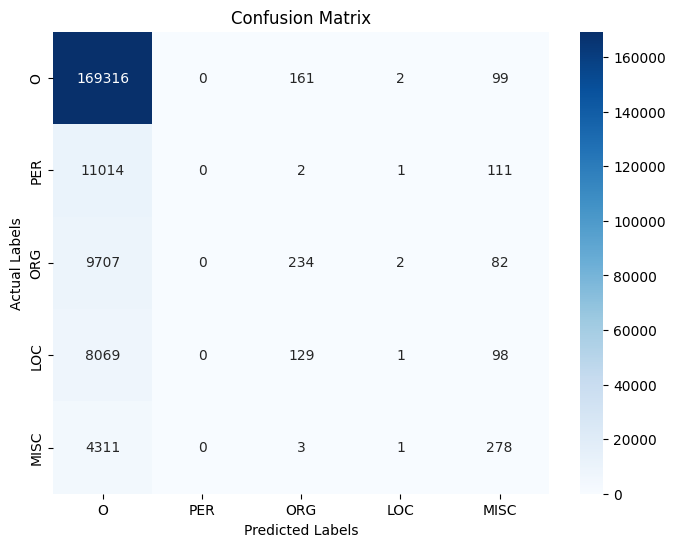


-----------
Test results:
Tagging...


100%|██████████| 3490/3490 [00:15<00:00, 231.01it/s]


---- 3490 lines tagged in 15.1115s ----
Overall accuracy: 0.839485800431895

Tags:  {0: 'O', 1: 'PER', 2: 'ORG', 3: 'LOC', 4: 'MISC'}
F-1 scores:  [0.91326757 0.         0.03306486 0.         0.10676157]


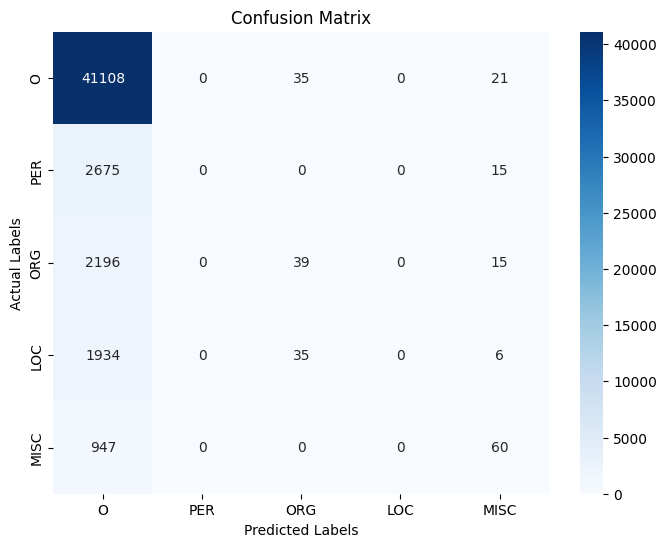

In [31]:
runMEMM(
    train_corpus = train_corpus,
    test_corpus = test_corpus,
    dic = dic,
    decode_type = 'greedy',
    regex_features=regex_features,
    rear_context_window=4,
    forward_context_window=4,
    num_prior_tags=5,
    output_file = None
)

## Add Regex features for problem 2(b)

In [ ]:
regex_features_2 = {
    # 'feature name': r'pattern',  # intuition for these features
    'ENDS_IN_AN': r'(an|AN)$',  # words like Samoan, INDIAN, etc.
    'LEN_TWO_AND_CAPS': r'^[A-Z]{2}$',  # Locations like CA, UK, etc.
    'IS_PERIOD': r'^\.$',  # . is common and usually O

    # TODO: Add at least 3 new regular expression features to improve model performance
    # (8 points)
    # START HERE
    'starts_with_capital': r'[A-Z]',
    'ending_ing':r'\w+ing',
    'Names': r'\b[A-Z][a-z]+(?:\s[A-Z][a-z]+)*\b',
    # 'days':r'\b(?:Monday|Tuesday|Wednesday|Thursday|Friday|Saturday|Sunday)\b',
    # 'org':r'\b[A-Z][a-z]+ (Inc|Corp|Ltd)\.',
    # 'months':r'\b(?:January|February|March|April|May|June|July|August|September|October|November|December)\b'
    # END
}



Extracting features...


100%|██████████| 14041/14041 [00:09<00:00, 1485.59it/s]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Training MaxEnt model. This usually finishes within 1-3 minutes.


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          470     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27715D+05    |proj g|=  1.28854D+05

At iterate   50    f=  5.40821D+04    |proj g|=  8.12331D+01

At iterate  100    f=  5.39928D+04    |proj g|=  1.31976D+01

At iterate  150    f=  5.39817D+04    |proj g|=  1.80496D+01

At iterate  200    f=  5.39773D+04    |proj g|=  6.60329D+00

At iterate  250    f=  5.39733D+04    |proj g|=  3.63125D+00

At iterate  300    f=  5.39720D+04    |proj g|=  1.80654D+00

At iterate  350    f=  5.39717D+04    |proj g|=  3.56083D+00

At iterate  400    f=  5.39717D+04    |proj g|=  4.01217D-01

At iterate  450    f=  5.39716D+04    |proj g|=  4.28110D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

100%|██████████| 14041/14041 [00:12<00:00, 1136.76it/s]


---- 14041 lines tagged in 12.3563s ----
Overall accuracy: 0.8696401648160063

Tags:  {0: 'O', 1: 'PER', 2: 'ORG', 3: 'LOC', 4: 'MISC'}
F-1 scores:  [0.94915901 0.51169578 0.26241227 0.29820764 0.2891819 ]


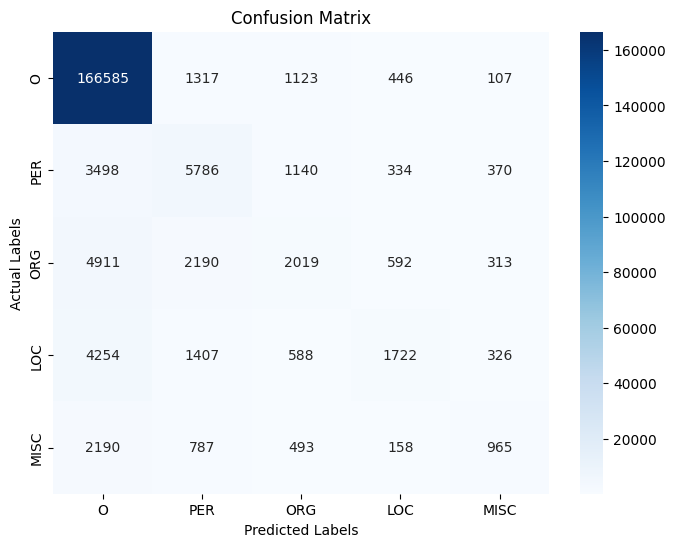


-----------
Test results:
Tagging...


100%|██████████| 3490/3490 [00:05<00:00, 625.80it/s] 


---- 3490 lines tagged in 5.5783s ----
Overall accuracy: 0.8709407977834821

Tags:  {0: 'O', 1: 'PER', 2: 'ORG', 3: 'LOC', 4: 'MISC'}
F-1 scores:  [0.94421072 0.51380689 0.2077676  0.34012147 0.28633406]


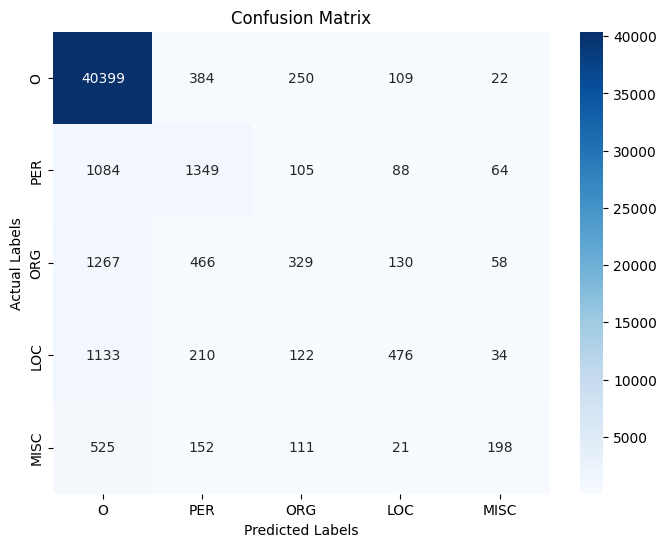

In [38]:
runMEMM(
    train_corpus = train_corpus,
    test_corpus = test_corpus,
    dic = dic,
    decode_type = 'greedy',
    regex_features=regex_features_2,
    rear_context_window=4,
    forward_context_window=4,
    num_prior_tags=5,
    output_file = None
)

TODO (5 points)

Please write down in the **text cell** your observations about how the extra regex features affect performance? Which ones help the most and which ones don't help much? Why do you think that is the case?

(You don't need to add this to the pdf write-up.)




In [40]:
'''
Tags:         {0: 'O',   1: 'PER', 2: 'ORG', 3:  'LOC', 4:   'MISC'}
F-1 scores:  [0.93341633 0.50139691 0.13593381 0.31788079 0.26827537] with capital letter
F-1 scores:  [0.91327386 0.         0.03306486 0.         0.10983171] removed capital letters
F-1 scores:  [0.92812011 0.20010157 0.20175724 0.08959157 0.28760088] removed capital letters and added names regex 
F-1 scores:  [0.94291256 0.51354988 0.21299188 0.33428571 0.28571429] capital letters + names <leave them>
F-1 scores:  [0.94291256 0.51354988 0.21299188 0.33428571 0.28571429] same F1 when We remove org regex then its not important <remove org>
F-1 scores:  [0.94516261 0.51178578 0.20369231 0.37307824 0.27944404] added days of week no significant effect <remove>
F-1 scores:  [0.94421072 0.51380689 0.2077676  0.34012147 0.28633406] added months <removed>
'''

"\nTags:         {0: 'O',   1: 'PER', 2: 'ORG', 3:  'LOC', 4:   'MISC'}\nF-1 scores:  [0.93341633 0.50139691 0.13593381 0.31788079 0.26827537] with capital letter\nF-1 scores:  [0.91327386 0.         0.03306486 0.         0.10983171] removed capital letters\nF-1 scores:  [0.92812011 0.20010157 0.20175724 0.08959157 0.28760088] removed capital letters and added names regex \nF-1 scores:  [0.94291256 0.51354988 0.21299188 0.33428571 0.28571429] capital letters + names <leave them>\nF-1 scores:  [0.94291256 0.51354988 0.21299188 0.33428571 0.28571429] same F1 when We remove org regex then its not important <remove org>\nF-1 scores:  [0.94516261 0.51178578 0.20369231 0.37307824 0.27944404] added days of week no significant effect <remove>\nF-1 scores:  [0.94421072 0.51380689 0.2077676  0.34012147 0.28633406] added months <removed>\n"